# Filter out only team USA and predict the current points

In [1]:
#general
import io
import os
import shutil
import requests
import base64

#pandas
import pandas as pd

#TensorFlow
import tensorflow as tf
#numpy
import numpy as np

#matplotlib.pylot
import matplotlib.pyplot as plt

#sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [3]:
#path
path = "/Users/petronillagriffith/desktop/Fifa/fifa"

#import file
filename = os.path.join(path, "USA.csv")

#names each column
names = ['rank', 'country', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
          'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 
          'two_year_ago_avg_weighted', 'three_year_ago_avg_', 'three_year_ago_avg_weighted', 'confederation', 'rank_date']

#making a DataFrame
df = pd.read_csv(filename, encoding = "ISO-8859-1", sep=',', na_values=['-1'], index_col=False)

#writes out "Starting File:"
print("Starting File:")


print(df[20:100])


print()

#writes out "Ending File:"
print("Ending File:")

print(df[-10:1])

Starting File:
    rank country_full country_abrv  total_points  previous_points  \
20    28          USA          USA        779.25              733   
21    29          USA          USA        779.25              779   
22    28          USA          USA        798.28              779   
23    22          USA          USA        865.10              798   
24    19          USA          USA        959.80              865   
25    13          USA          USA        995.75              960   
26    13          USA          USA       1039.80              996   
27    14          USA          USA       1018.71             1040   
28    14          USA          USA       1018.71             1019   
29    14          USA          USA       1018.71             1019   
30    13          USA          USA       1043.70             1019   
31    14          USA          USA       1017.32             1044   
32    13          USA          USA       1014.50             1017   
33    14          U

In [4]:
df.head(5)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,confederation,rank_date
0,28,USA,USA,791.44,777,2.0,335.41,335.41,430.01,215.01,597.61,179.28,308.68,61.74,CONCACAF,8/24/11
1,31,USA,USA,741.45,791,-3.0,290.69,290.69,380.25,190.13,604.26,181.28,396.74,79.35,CONCACAF,9/21/11
2,34,USA,USA,719.61,741,-3.0,298.14,298.14,308.72,154.36,634.66,190.40,383.53,76.71,CONCACAF,10/19/11
3,34,USA,USA,720.85,720,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,CONCACAF,11/23/11
4,34,USA,USA,720.85,721,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,CONCACAF,12/21/11


In [5]:
a = df['country_full'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['country_full_class'] = df['country_full'].map(lambda x: byte_offset_map[x])

In [6]:
a = df['country_abrv'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['country_abrv_class'] = df['country_abrv'].map(lambda x: byte_offset_map[x])

In [7]:
a = df['confederation'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['confederation_class'] = df['confederation'].map(lambda x: byte_offset_map[x])

In [8]:
a = df['rank_date'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['rank_date_class'] = df['rank_date'].map(lambda x: byte_offset_map[x])

In [9]:
df

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,confederation,rank_date,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,28,USA,USA,791.44,777,2.0,335.41,335.41,430.01,215.01,597.61,179.28,308.68,61.74,CONCACAF,8/24/11,0,0,0,0
1,31,USA,USA,741.45,791,-3.0,290.69,290.69,380.25,190.13,604.26,181.28,396.74,79.35,CONCACAF,9/21/11,0,0,0,1
2,34,USA,USA,719.61,741,-3.0,298.14,298.14,308.72,154.36,634.66,190.40,383.53,76.71,CONCACAF,10/19/11,0,0,0,2
3,34,USA,USA,720.85,720,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,CONCACAF,11/23/11,0,0,0,3
4,34,USA,USA,720.85,721,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,CONCACAF,12/21/11,0,0,0,4
5,33,USA,USA,720.85,721,1.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,CONCACAF,1/18/12,0,0,0,5
6,31,USA,USA,750.47,721,2.0,308.64,308.64,371.15,185.58,539.98,162.00,471.24,94.25,CONCACAF,2/15/12,0,0,0,6
7,27,USA,USA,771.60,750,4.0,321.57,321.57,405.60,202.80,509.94,152.98,471.24,94.25,CONCACAF,3/7/12,0,0,0,7
8,29,USA,USA,778.69,772,-2.0,350.25,350.25,360.82,180.41,510.95,153.29,473.71,94.74,CONCACAF,4/11/12,0,0,0,8
9,29,USA,USA,778.69,779,0.0,350.25,350.25,360.82,180.41,510.95,153.29,473.71,94.74,CONCACAF,5/9/12,0,0,0,9


In [10]:
#Drops the 'country' column from the data set
df = df.drop(['country_full'], axis=1)

In [11]:
#Drops the 'country' column from the data set
df = df.drop(['country_abrv'], axis=1)

In [12]:
#Drops the 'confederation' column from the data set
df = df.drop(['confederation'], axis=1)

In [13]:
#Drops the 'confederation' column from the data set
df = df.drop(['rank_date'], axis=1)

In [14]:
df.head(5)

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,28,791.44,777,2.0,335.41,335.41,430.01,215.01,597.61,179.28,308.68,61.74,0,0,0,0
1,31,741.45,791,-3.0,290.69,290.69,380.25,190.13,604.26,181.28,396.74,79.35,0,0,0,1
2,34,719.61,741,-3.0,298.14,298.14,308.72,154.36,634.66,190.40,383.53,76.71,0,0,0,2
3,34,720.85,720,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,0,0,0,3
4,34,720.85,721,0.0,285.53,285.53,358.73,179.37,583.78,175.13,404.11,80.82,0,0,0,4


In [15]:
len(df)

83

In [16]:
max = df.loc[df['country_full_class'].idxmax()]

In [17]:
total_country = max['country_full_class']

In [18]:
total_country

0.0

In [19]:
df.dtypes

rank                             int64
total_points                   float64
previous_points                  int64
rank_change                    float64
cur_year_avg                   float64
cur_year_avg_weighted          float64
last_year_avg                  float64
last_year_avg_weighted         float64
two_year_ago_avg               float64
two_year_ago_avg_weighted      float64
three_year_ago_avg             float64
three_year_ago_avg_weighted    float64
country_full_class               int64
country_abrv_class               int64
confederation_class              int64
rank_date_class                  int64
dtype: object

In [38]:
df.isnull().values.any()

False

In [40]:
df_norm = (df - df.mean()) / (df.max() - df.min())

In [41]:
df = df_norm

In [42]:
#x, y = to_xy(df,'total_points')

#y = df['total_points']


#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
#print(x_train.shape)
#print(x_test.shape)


In [43]:
x = int(len(df)*.7)
pt_to_split = int(x)
print(pt_to_split)

47


In [44]:
x = df
x_train= df[:pt_to_split]
x_test = df[pt_to_split:]
print(x_train.shape)
print(x_test.shape)

(47, 16)
(21, 16)


In [47]:
y = df['total_points']
y_train = y[:pt_to_split]
y_test = y [pt_to_split:]
print(y_train.shape)
print(y_test.shape)

(47,)
(21,)


In [48]:
#df = df.drop(['rank_change'], axis=1)

In [49]:
nan_rows = df[df.isnull().T.any().T]
nan_rows

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,0.072251,-0.108926,-0.145033,0.081232,-0.164824,-0.164824,0.050599,0.050621,0.358759,0.358723,-0.297364,-0.297308,NaN,NaN,NaN,-0.487836
1,0.202685,-0.243463,-0.106466,-0.156863,-0.262776,-0.262776,-0.062655,-0.062629,0.373325,0.373325,-0.091847,-0.091823,NaN,NaN,NaN,-0.475490
2,0.333120,-0.302241,-0.244207,-0.156863,-0.246458,-0.246458,-0.225456,-0.225449,0.439911,0.439908,-0.122677,-0.122629,NaN,NaN,NaN,-0.463145
3,0.333120,-0.298904,-0.302058,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.450799
4,0.333120,-0.298904,-0.299303,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.438453
5,0.289642,-0.298904,-0.299303,0.033613,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.426107
6,0.202685,-0.219188,-0.299303,0.081232,-0.223460,-0.223460,-0.083366,-0.083340,0.232529,0.232564,0.082023,0.082039,NaN,NaN,NaN,-0.413762
7,0.028772,-0.162321,-0.219413,0.176471,-0.195139,-0.195139,-0.004958,-0.004957,0.166732,0.166710,0.082023,0.082039,NaN,NaN,NaN,-0.401416
8,0.115729,-0.143240,-0.158807,-0.109244,-0.132320,-0.132320,-0.106877,-0.106873,0.168944,0.168973,0.087788,0.087757,NaN,NaN,NaN,-0.389070
9,0.115729,-0.143240,-0.139524,-0.014006,-0.132320,-0.132320,-0.106877,-0.106873,0.168944,0.168973,0.087788,0.087757,NaN,NaN,NaN,-0.376725


In [50]:
len(nan_rows)

68

In [51]:
df = df[pd.notnull(df['rank_change'])]

In [58]:
df.head(5)

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,0.072251,-0.108926,-0.145033,0.081232,-0.164824,-0.164824,0.050599,0.050621,0.358759,0.358723,-0.297364,-0.297308,NaN,NaN,NaN,-0.487836
1,0.202685,-0.243463,-0.106466,-0.156863,-0.262776,-0.262776,-0.062655,-0.062629,0.373325,0.373325,-0.091847,-0.091823,NaN,NaN,NaN,-0.475490
2,0.333120,-0.302241,-0.244207,-0.156863,-0.246458,-0.246458,-0.225456,-0.225449,0.439911,0.439908,-0.122677,-0.122629,NaN,NaN,NaN,-0.463145
3,0.333120,-0.298904,-0.302058,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.450799
4,0.333120,-0.298904,-0.299303,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.438453


In [57]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(47, 16)
(21, 16)
(47,)
(21,)


In [54]:
y_train = y_train.values.reshape(58,1)
y_test = y_test.values.reshape(25,1)

ValueError: cannot reshape array of size 47 into shape (58,1)

In [59]:
x = int(len(df)*.7)
pt_to_split = int(x)

In [64]:
pt_to_split

47

In [67]:
df_train = df[:pt_to_split]
df_test = df[pt_to_split:]

spots_train = df_train['total_points'].tolist()
spots_test = df_test['total_points'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 47 observations.
Test set has 21 observations.


In [68]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []
    
    for i in range(len(obs)-SEQUENCE_SIZE-1):
        #print(i)
        window = obs[i: (i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 5

x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (41, 5, 1)
Shape of test set: (15, 5, 1)


In [69]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0, input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.summary()

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=1,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

Build model...
Train...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
Train on 41 samples, validate on 15 samples
Epoch 1/1000
41/41 [==============================] - 1s 13ms/step - loss: 0.0654 - val_loss: 0.0078
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0542 - val_loss: 0.0071
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0457 - val_loss: 0.0070
Epoch 4/1000
41/41 [=============

In [70]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.0836901702741557


In [71]:
pred

array([[ 0.03060933],
       [ 0.04059333],
       [ 0.0389761 ],
       [ 0.03775316],
       [ 0.02894836],
       [ 0.02668646],
       [ 0.02867472],
       [ 0.03941109],
       [ 0.01379745],
       [ 0.02643476],
       [ 0.02311481],
       [ 0.02487941],
       [ 0.03249197],
       [ 0.05467801],
       [ 0.05877224]], dtype=float32)

In [72]:
df.head(5)

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,0.072251,-0.108926,-0.145033,0.081232,-0.164824,-0.164824,0.050599,0.050621,0.358759,0.358723,-0.297364,-0.297308,NaN,NaN,NaN,-0.487836
1,0.202685,-0.243463,-0.106466,-0.156863,-0.262776,-0.262776,-0.062655,-0.062629,0.373325,0.373325,-0.091847,-0.091823,NaN,NaN,NaN,-0.475490
2,0.333120,-0.302241,-0.244207,-0.156863,-0.246458,-0.246458,-0.225456,-0.225449,0.439911,0.439908,-0.122677,-0.122629,NaN,NaN,NaN,-0.463145
3,0.333120,-0.298904,-0.302058,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.450799
4,0.333120,-0.298904,-0.299303,-0.014006,-0.274079,-0.274079,-0.111634,-0.111607,0.328466,0.328424,-0.074647,-0.074671,NaN,NaN,NaN,-0.438453


In [73]:
%matplotlib inline
from matplotlib.pyplot import figure, show

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [75]:
print(pred.shape)
y_test = y_test.reshape(15,1)
print(y_test.shape)

(15, 1)
(15, 1)


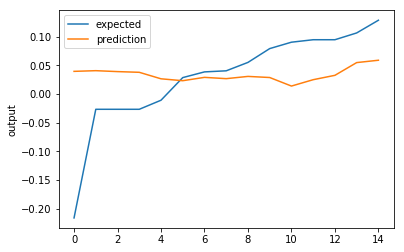

In [76]:
# Plot the chart
chart_regression(pred.flatten(),y_test)

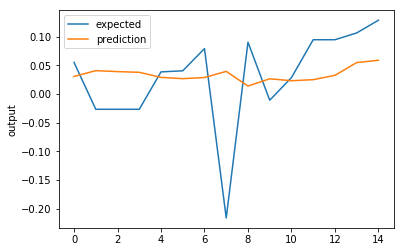

In [77]:
chart_regression(pred.flatten(),y_test,sort=False)

In [ ]:
y